In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

**The code below calculates the uv-plane coordinates sampled by a set of baselines for an observation. We just need to provide the East-North-Up coordinates of the antennas in the local tangent plane (from e.g. CASA simulator files or manually), and some details of the observation.**

In [2]:
def ltp_to_Dazel(bl_vec):
    """Convert local tangent plane coordinates of a baseline vector to length (D), azimuth, and elevation."""
    D = np.sqrt(np.sum(bl_vec**2)) # baseline length
    az = np.rad2deg(np.arctan2(bl_vec[0], bl_vec[1]))
    if az < 0.0:
        az += 360.
    el = np.rad2deg(np.sin(bl_vec[2]/D))
    return D, az, el


def Dazel_to_XYZ(D, az, el, lat):
    """Convert a baseline length, azimuth, and elevation to XYZ coordinate system."""
    # convert to radians for numpy
    az *= (np.pi/180.)
    el *= (np.pi/180.)
    lat *= (np.pi/180.)
    # eqn 4.4 of thomson moran and swenson
    X = D*(np.cos(lat)*np.sin(el) - np.sin(lat)*np.cos(el)*np.cos(az))
    Y = D*(np.cos(el)*np.sin(az))
    Z = D*(np.sin(lat)*np.sin(el) + np.cos(lat)*np.cos(el)*np.cos(az))
    return X, Y, Z

def XYZ_to_uvw(X, Y, Z, H_deg, dec_deg, obs_wl):
    """Given XYZ baseline coordinates and a source hour angle and declination, return"""
    # convert baseline lengths to lambda
    X_lam = X/obs_wl
    Y_lam = Y/obs_wl
    Z_lam = Z/obs_wl
    # convert angles to radians for numpy
    H = H_deg*(np.pi/180.)
    dec = dec_deg*(np.pi/180.)
    # calculate u,v,w - equation 4.1 of thomson moran and swenson
    u = X_lam*np.sin(H) + Y_lam*np.cos(H)
    v = X_lam*-np.sin(dec)*np.cos(H) + Y_lam*np.sin(dec)*np.sin(H) + Z_lam*np.cos(dec)
    w = X_lam*np.cos(dec)*np.cos(H) - Y_lam*np.cos(dec)*np.sin(H) + Z_lam*np.sin(dec)
    return u, v, w


def antenna_pairs(N_ants):
    """Return all unique combinations of antennas ignoring order."""
    pairs = []
    for i in range(N_ants):
        for j in range(N_ants):
            new_pair = True
            # no pairs of same antenna i.e autocorellations
            if i == j:
                new_pair = False
            for p in pairs:
                # don't add antenna pair if already present, order doesn't matter
                if (p[0] == i and p[1] == j) or (p[0] == j and p[1] == i):
                    new_pair = False
                    break
            if new_pair:
                pairs.append((i,j))
    return pairs


def beam_from_uv(u, v, l, m):
    """return a normalized beam image for given uv-coordinates"""
    im = np.zeros_like(l)
    for u0, v0 in zip(u, v):
        im += 2.0*np.cos(2.0*np.pi*(u0*l+v0*m))
    # normalize
    im /= im.max()
    return im

**Let's first setup a variety of arrays to use.**

In [3]:
sma_subcompact = np.genfromtxt('sma.subcompact.cfg')[:,0:3]
alma_7m = np.genfromtxt('aca.cycle7.cfg')[:,0:3]
alma_12m_compact = np.genfromtxt('alma.cycle7.3.cfg')[:,0:3]
alma_12m_intermediate = np.genfromtxt('alma.cycle7.6.cfg')[:,0:3]
alma_12m_extended = np.genfromtxt('alma.cycle7.9.cfg')[:,0:3]
vla_A = np.genfromtxt('vla.a.cfg')[:,0:3]
vla_D =  np.genfromtxt('vla.d.cfg')[:,0:3]

# simple arrays, altar as you please - coordinates are local tangent plane xyz coordinates in meters
# with east-noth-up convention, that is +x = East, +y = North, +z = Up.
array_2ant = np.array([[0.,  0., 0.],
                      [14.14, 14.14, 0.]])
array_3ant = np.array([[0.,  0., 0.],
                      [14.14, 14.14, 0.],
                      [-10, 5, 0.]])
array_4ant = np.array([[0.,  0., 0.],
                      [14.14, 14.14, 0.],
                      [-10, 5, 0.],
                      [2., 2., 0.]])
array_5ant = np.array([[0.,  0., 0.],
                      [14.14, 14.14, 0.],
                      [-10, 5, 0.],
                      [2., 2., 0.],
                      [10., 7.5, 0.]])

**Excercise: Choose different arrays by setting array_xyz and plot the antenna positions.**

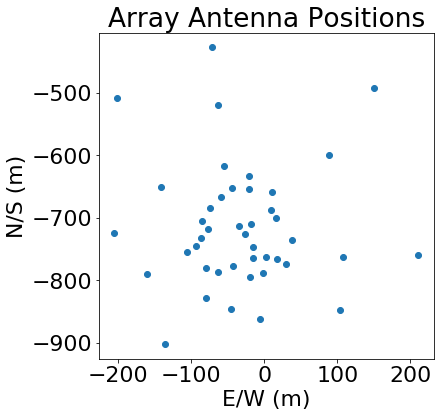

In [7]:
array_xyz = alma_12m_compact
obs_lat = -23 # lattitude of the observatory. ALMA is at about -23, VLA at +34, and SMA at +19
N_ants=len(array_xyz)

# Plot the antenna positions
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(6,6))
plt.scatter(array_xyz[:,0], array_xyz[:,1])
plt.xlabel('E/W (m)')
plt.ylabel('N/S (m)')
plt.title('Array Antenna Positions')
plt.show()

**The code below sets up an observation (first block) then calculates the uv-coverage and plots the resulting beam.**

**Exercises:**

1.a Start with the 2 antenna array. What happens to the beam when you change the antenna separations?

1.b What happens to the beam when you change the observing wavelength?

1.c What happens when you change the antenna orientations?

2\. Change to the 3 antenna array and repeat the above. Try adding more and more antennas. What happens to the beam?

3\. Load the alma_12m_intermediate  array. How many antennas are there? About how large is the main lobe of the primary beam at a wavelength of 1 mm? Note: you will need to change the image plane grid size to see the main lobe, try making it 4 arcsec across.

3.a. Change hour_angles below to observe for 1 hour around the transit of the meridian (hour angle 0) with 20 integrations. What happens to the points in the uv-plane? What changes about the beam shape?

3.b. What happens as you continue to increase the range of observing angles?

3.c. What happens if you increase the number of integrations?

4.a Change the observatory lattitude in array setup. What happens to the uv-sampling? What about the beam? Is the change the same in both directions?

4.b. Similarly, try changing the source declination. What would happen if we tried to observe a high lattitude northern hemisphere source with ALMA? Are sources observable at all hour angles?

5.\ Experiment with the different arrays, hour angle ranges, and wavelengths. Note that you may wish to increase or decrease the image plane grid size and resolution to better visualize the beam. What resolution can be acheived with the ALMA extended configuration in 4 hours at 1mm? Or the SMA subcompact in the same time? How about the VLA A configuration at 1cm?



In [8]:
obs_wl = 1.0e-2  # observing wavelength, meters. 
# ALMA can observe from 0.3 to 9.6mm, SMA from 0.3 to 17mm, and  the VLA from 0.6cm to 410 cm
source_dec = -25. # Source declination in degrees

# set observing track length and number of integrations.
# recall 1 hour = 15 degrees across sky, so e.g. -30 to 30 degrees is 4 hours of observing near the source transit.
# Note also that we should provide hour angles where the source is above the horizon! we can not see through
# the earth!
n_int = 20
#hour_angles = 0
hour_angles = np.linspace(-10, 10, n_int)

# image plane grid setup for plotting the beam - change this to zoom in/out on the 
arcsec_rad = 1.0/206264.806 # an arsecond in units of radians
lm_grid_size = 60. # image pixel size in arcsec

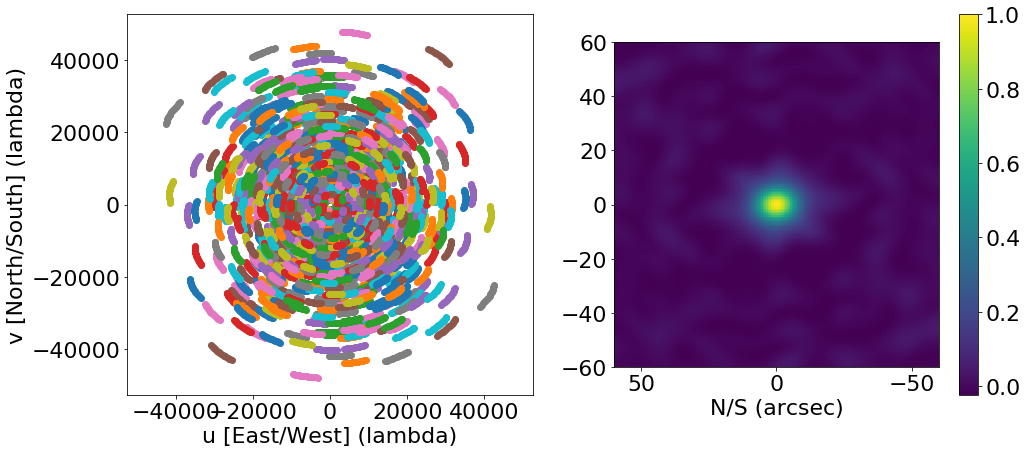

In [9]:
# calculate all unique antenna combinations, i.e. the number of baselines
pairs = antenna_pairs(N_ants)
n_bl = len(pairs)

# Setup empty numpy arrays to hold uv-coordinates
u_track = np.zeros(n_int*n_bl) 
v_track = np.zeros(n_int*n_bl)

# optional: timing for performance 
#import time
#start_time = time.time()

# calculate and plot uv-coverage for our source given the observing parameters
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,7))
plt.rcParams.update({'font.size': 22})
for i, pair in enumerate(pairs):
    ant1 = array_xyz[pair[0]]
    ant2 = array_xyz[pair[1]]
    bl_vec = ant2 - ant1
    X, Y, Z = Dazel_to_XYZ(*ltp_to_Dazel(bl_vec), obs_lat)
    u, v, w = XYZ_to_uvw(X, Y, Z, hour_angles, source_dec, obs_wl)
    ax1.scatter([u, -u], [v,-v])
    u_track[i*n_int:(i+1)*n_int] = u 
    v_track[i*n_int:(i+1)*n_int] = v
    
#print("--- %s seconds ---" % (time.time() - start_time))

max_uv = np.maximum(np.abs(u_track).max(), np.abs(v_track).max())
ax1.set_xlim((-max_uv*1.1, 1.1*max_uv))
ax1.set_ylim((-max_uv*1.1, 1.1*max_uv))
ax1.set_xlabel('u [East/West] (lambda)')
ax1.set_ylabel('v [North/South] (lambda)')

# calculate and plot beam
lm_grid = np.linspace(-lm_grid_size/2, lm_grid_size/2, 201)*arcsec_rad
l, m = np.meshgrid(lm_grid, lm_grid)

beam = beam_from_uv(u_track, v_track, l, m)
m = ax2.imshow(beam, origin='lower',
               extent=(lm_grid_size, -lm_grid_size, -lm_grid_size, lm_grid_size),
              #norm=mcolors.PowerNorm(0.5)
              )
ax2.set_xlabel('E/W (arcsec)')
ax2.set_xlabel('N/S (arcsec)')
plt.colorbar(m)
plt.show()